In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from inox.random import PRNG
from tqdm import trange
from typing import *

from utils import *

In [2]:
rng = PRNG(0)

## Data

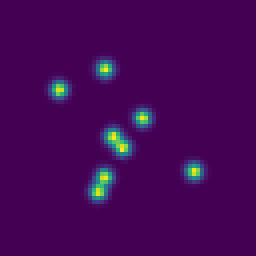

In [3]:
modes = rng.uniform((8, 5), minval=-2.0, maxval=2.0)

i = rng.randint((65536,), minval=0, maxval=len(modes))
x = rng.normal((65536, 5)) / 8
x = modes[i] + x

show(x)

In [4]:
def measure(A, x):
    return jnp.einsum('...ij,...j->...i', A, x)

A = rng.normal((65536, 2, 5))
A = A / jnp.linalg.norm(A, axis=-1, keepdims=True)
y = measure(A, x) + 1e-3 * rng.normal((65536, 2))

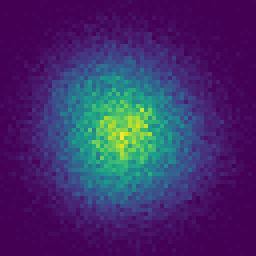

In [5]:
def sample(model, A, y):
    sampler = PredictorCorrector(
        PosteriorScoreModel(
            model=model,
            A=inox.Partial(measure, A),
            y=y,
            sigma_y=1e-3,
        ),
        tau=0.5,
    )

    z = rng.normal((len(y), 5))
    x = sampler(z, steps=1024, key=rng.split())

    return x

x_bis = sample(StandardScoreModel(), A, y)
show(x_bis)

## Training

In [6]:
def train(x, A, steps=65536):
    model = make_model(key=rng.split())
    static, params, others = model.partition(nn.Parameter)

    scheduler = optax.linear_schedule(init_value=1e-4, end_value=1e-6, transition_steps=steps)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    objective = DDPMLoss()

    def ell(params, others, x, A, key):
        keys = jax.random.split(key, 2)

        z = jax.random.normal(keys[0], shape=x.shape)
        t = jax.random.beta(keys[1], a=3, b=5, shape=x.shape[:1])

        return objective(static(params, others), x, z, t, A=inox.Partial(measure, A))

    @jax.jit
    def sgd_step(params, others, opt_state, x, A, key):
        loss, grads = jax.value_and_grad(ell)(params, others, x, A, key)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state

    for step in (bar := trange(steps)):
        i = rng.randint(shape=(1024,), minval=0, maxval=len(y))

        loss, params, opt_state = sgd_step(params, others, opt_state, x[i], A[i], rng.split())

        bar.set_postfix(loss=float(loss))

    return static(params, others)

100%|██████████| 65536/65536 [08:30<00:00, 128.48it/s, loss=0.849]


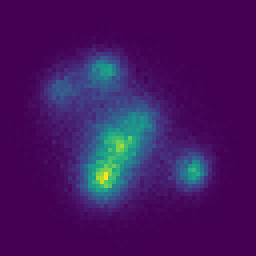

In [7]:
model = train(x_bis, A)
x_bis = sample(model, A, y)
show(x_bis)

100%|██████████| 65536/65536 [08:29<00:00, 128.66it/s, loss=0.738]


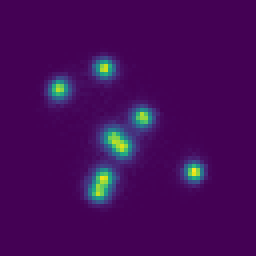

In [8]:
model = train(x_bis, A)
x_bis = sample(model, A, y)
show(x_bis)

100%|██████████| 65536/65536 [08:29<00:00, 128.56it/s, loss=0.705]


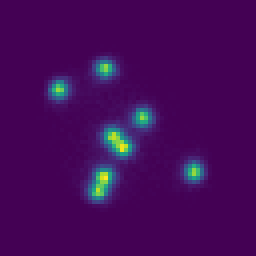

In [9]:
model = train(x_bis, A)
x_bis = sample(model, A, y)
show(x_bis)

100%|██████████| 65536/65536 [08:30<00:00, 128.45it/s, loss=0.672]


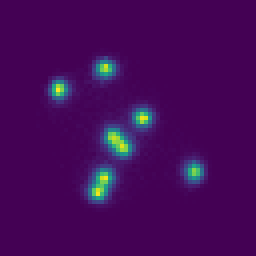

In [10]:
model = train(x_bis, A)
x_bis = sample(model, A, y)
show(x_bis)

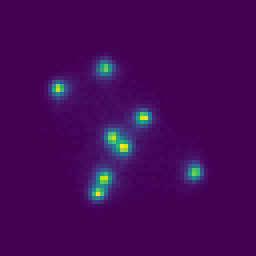

In [11]:
sampler = Euler(model)
x_ter = sampler(rng.normal(x.shape), steps=256)
show(x_ter)